# Experiment: Holdout Pipeline - Online Classification

In this exemplary experiment we use float to compare three online classifiers with respect to different performance measures. We use a holdout evaluation strategy.

The holdout pipeline can be used similarly to the prequential pipeline. Hence, **for more detailed information, e.g. regarding feature selection, concept drift detection, or additional visualization options, please see one of the experiments for the prequential pipeline.**

In [1]:
# Optional: Rebase the file path.
# Note that you may also provide explicit file paths and avoid this step.
import os
os.chdir(os.getcwd()[:-18])

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from skmultiflow.trees import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier
from river.linear_model import Perceptron, LogisticRegression

# Import float modules
from float.data import DataLoader
from float.data.preprocessing import SklearnScaler
from float.pipeline import HoldoutPipeline
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.river import RiverClassifier
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.evaluation.measures import noise_variability
import float.visualization as fvis

### Setup *float* modules

#### Create a DataLoader object
We load the Electricity data set and specify a sklearn MinMaxScaler for the normalization.

In [3]:
data_loader = DataLoader(path='float/data/datasets/electricity.csv',  # This path might have to be adjusted!
                         target_col=-1,
                         scaler=SklearnScaler(MinMaxScaler())
                         )

#### Create Predictor objects
We setup a list of predictors. Specifically, we want to compare models from skmultiflow and river. We use the default parameters of the packages, however, in general you can provide any configuration you like.

In [4]:
predictors = [SkmultiflowClassifier(model=HoeffdingAdaptiveTreeClassifier(), classes=data_loader.stream.target_values),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), classes=data_loader.stream.target_values),
              RiverClassifier(model=LogisticRegression(), feature_names=data_loader.stream.feature_names)
              ]

#### Create a PredictorEvaluator object.
The evaluator will compute and store the performance measures when running the pipeline. Float automatically clones the provided evaluator for each specified predictor object.

We specify a fading factor, i.e. the evaluator will additionally store aggregated measures with an exponential decay.

Note you can hand any parameter of a measure function directly to the Evaluator, e.g. below we specify the zero_division parameter of the precision_score and the reference_measure and n_samples parameters of the noise_variability.

In [5]:
evaluator = PredictionEvaluator(measure_funcs=[accuracy_score, precision_score, noise_variability],
                                decay_rate=0.1,
                                zero_division=0,
                                reference_measure=accuracy_score,
                                n_samples=15)

#### Create and run a HoldoutPipeline

We use a batch-incremental scheme, processing the data in batches of size 10. Moreover, we pretrain the classifiers on 200 observations and set a random state for reproducibility.

For the holdout evaluation, we need to provide a **test_set**. If we do not provide a test set ourselves, the HoldoutPipeline will automatically use the first batch as test set.

The **test_interval** specifies the frequency in which we perform tests using the holdout set. Here, we specify that we want to test the models at every 100th time step.

The **test_replace_interval** allows us to update the test set over time. In particular, we want to use every x'th observation to replace the oldest instance in the test set. Below, we tell the pipeline to use every 50th new observation for testing. In this way, we can maintain a representative holdout set over time.

In [6]:
# We sample a holdout set and reset the data stream afterwards.
holdout_set = data_loader.get_data(100)
data_loader.stream.reset()

pipeline = HoldoutPipeline(data_loader=data_loader,
                           predictor=predictors,
                           prediction_evaluator=evaluator,
                           batch_size=10,
                           n_pretrain=200,
                           n_max=data_loader.stream.n_samples,  # We use all observations
                           test_set=holdout_set,
                           test_interval=100,
                           test_replace_interval = 50,
                           random_state=0)
pipeline.run()

Pretrain the predictor with 200 observation(s).
[====================] 100%
################################## SUMMARY ##################################
Evaluation has finished after 16.182985067367554s
Data Set: float/data/datasets/electricity.csv
The HoldoutPipeline has processed 45312 instances, using batches of size 10.
-------------------------------------------------------------------------
*** Prediction ***
Model: SkmultiflowClassifier.HoeffdingAdaptiveTreeClassifier
| Performance Measure    |       Value |
|------------------------|-------------|
| Avg. Test Comp. Time   |  0.00280344 |
| Avg. Train Comp. Time  |  0.00153406 |
| Avg. accuracy_score    |  0.734255   |
| Avg. precision_score   |  0.805127   |
| Avg. noise_variability | -0.177844   |
Model: SkmultiflowClassifier.HoeffdingTreeClassifier
| Performance Measure    |        Value |
|------------------------|--------------|
| Avg. Test Comp. Time   |  0.00212979  |
| Avg. Train Comp. Time  |  0.000380088 |
| Avg. accu

The summarized results suggest that the HoeffdingTreeClassifier is superior to the remaining models w.r.t. the predictive performance. However, it has disadvantages regarding the variability under noisy inputs. We may get further insight into the performance of the classifiers by using the visualization module of float.

### Visualizing Results

Float provides standardized plot types that may be used to illustrate results stored in an evaluator object. 
However, note that you can essentially do whatever you like with the evaluator object, e.g. save it or create custom tables.

The evaluator object contains all results, e.g. performance measures and computation times, that were calculated during the pipeline run. Since we trained 3 predictors, the pipeline.prediction_evaluators object contains 3 evaluators.

We begin by illustrating the raw accuracy measures of each classifier using a regular line plot. Note that the HoldoutPipeline has only tested the models every 100th time step. That is, at all remaining time steps, the PredictorEvaluator has saved 'nan'. To plot the results of the holdout evaluation, we need to ignore these nan measures.

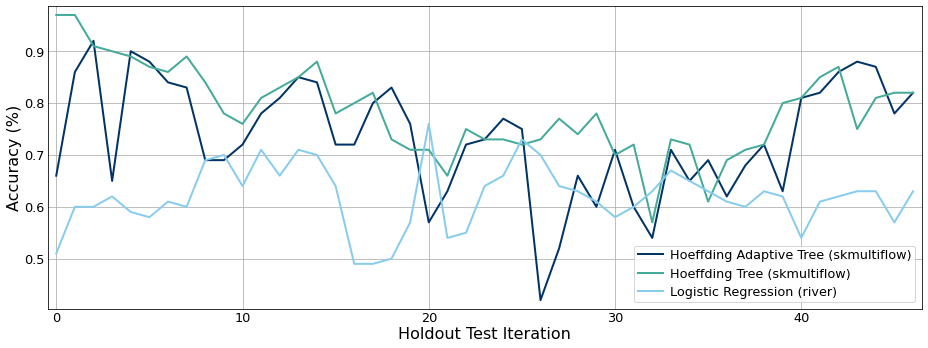

In [7]:
measures = []

for evaluator in pipeline.prediction_evaluators:
    meas = np.asarray(evaluator.result['accuracy_score']['measures'])
    not_nan_idx = ~np.isnan(evaluator.result['accuracy_score']['measures'])
    meas = meas[not_nan_idx]
    measures.append(meas)

ax = fvis.plot(measures=measures,
               legend_labels=['Hoeffding Adaptive Tree (skmultiflow)', 
                              'Hoeffding Tree (skmultiflow)', 
                              'Logistic Regression (river)'],
               y_label='Accuracy (%)')

ax.set_xlabel('Holdout Test Iteration')  # Relabel the x-axis as the default naming is not meaningful in this case.
plt.show()

As before, we may conclude that the HoeffdingTreeClassifier outperforms the remaining predictors. 

We can obtain a smoother plot, by showing the decayed mean and variance instead below. Other than for the raw measures shown above, the decayed mean measures do not contain nan values. That is, if the models are not tested at an iteration, the PredictionEvaluator simply does not udpate the decayed mean (this can be observed in the first plot below). The decayed mean is the only measure where such a behaviour is meaningful, as it is not affected by the number of tests involved in the averaging. In order to display the same test iterations as above, we may reuse the not_nan_idx variable.

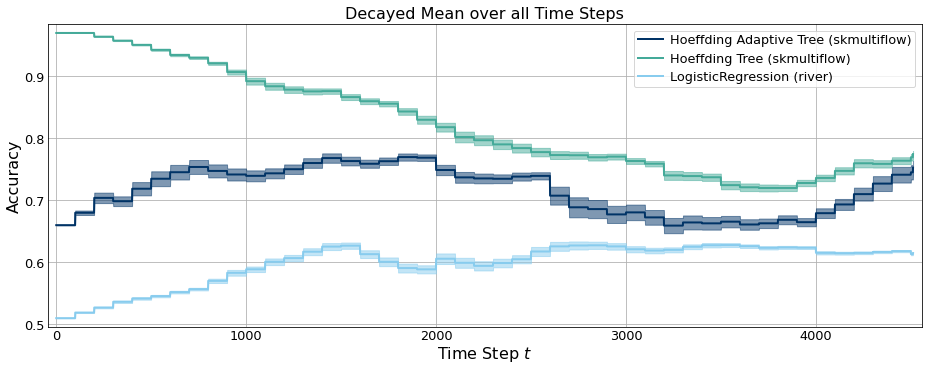

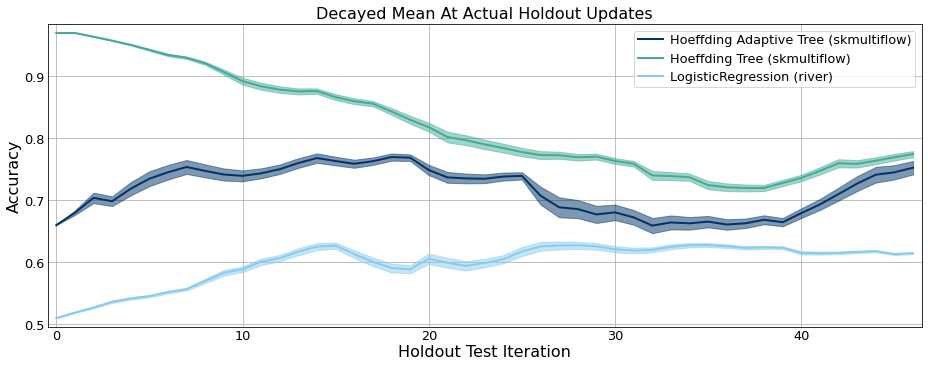

In [8]:
ax = fvis.plot(measures=[evaluator.result['accuracy_score']['mean_decay'] for evaluator in pipeline.prediction_evaluators],
               variance_measures=[evaluator.result['accuracy_score']['var_decay'] for evaluator in pipeline.prediction_evaluators],
               legend_labels=['Hoeffding Adaptive Tree (skmultiflow)',
                              'Hoeffding Tree (skmultiflow)', 
                              'LogisticRegression (river)'],
               y_label='Accuracy')

plt.title('Decayed Mean over all Time Steps', fontsize=16)
plt.show()

ax = fvis.plot(measures=[np.asarray(evaluator.result['accuracy_score']['mean_decay'])[not_nan_idx] for evaluator in pipeline.prediction_evaluators],
               variance_measures=[np.asarray(evaluator.result['accuracy_score']['var_decay'])[not_nan_idx] for evaluator in pipeline.prediction_evaluators],
               legend_labels=['Hoeffding Adaptive Tree (skmultiflow)',
                              'Hoeffding Tree (skmultiflow)', 
                              'LogisticRegression (river)'],
               y_label='Accuracy')

ax.set_xlabel('Holdout Test Iteration')  # Relabel the x-axis as the default naming is not meaningful in this case.
plt.title('Decayed Mean At Actual Holdout Updates', fontsize=16)
plt.show()


Note that global trends can often be identified more easily from an aggregated measure like the decayed mean, compared to the raw measurements shown before.